# Exponential Smoothing

In [90]:
# Packages
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import plotly.express as px
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.utils import resample  # For bootstrapping
import numpy as np
from scipy.special import inv_boxcox
import pickle


## Load data

In [91]:
# Read excel in ../Data/Clean_McBroken_Daily.xlsx
df = pd.read_excel('../Data/Clean_McBroken_Daily.xlsx')
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train
0,2020-10-25,354.0,6818.0,5.192138,221250.0,False,True
1,2020-10-26,373.0,6844.0,5.450029,233125.0,False,True
2,2020-10-27,427.0,7488.0,5.702457,266875.0,False,True
3,2020-10-28,391.0,8294.0,4.714251,244375.0,False,True
4,2020-10-29,374.0,7461.0,5.012733,233750.0,False,True
...,...,...,...,...,...,...,...
1577,2025-02-18,1359.0,11832.0,11.485801,849375.0,False,False
1578,2025-02-19,1190.0,11835.0,10.054922,743750.0,False,False
1579,2025-02-20,1207.0,11990.0,10.066722,754375.0,False,False
1580,2025-02-21,1110.0,11907.0,9.322247,693750.0,False,False


## Exponential Smoothing

In [92]:
# Count missing and outlier cases
print('Missing cases:', df['Revenue Losses'].isnull().sum())
# Mark missing cases
df['Missing'] = df['Revenue Losses'].isnull()
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 129
Outlier cases: 119


In [93]:
# Revenue Losses
fig = px.line(df, x='Date', y='Revenue Losses',
              title='Revenue Losses From Broken Machines ($625 per day per machine)',
              labels={'Revenue Losses': 'Revenue Losses'},
              line_shape='linear')

# Center title
fig.update_layout(title_x=0.5)

# Dollar format
fig.update_layout(yaxis_tickprefix='$')

# Show the plot
fig.show()

In [94]:
# For ETS, limit to past year + test period
df = df.iloc[-(365 + 30):].reset_index(drop=True)
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train,Missing
0,2024-01-25,140.0,1436.0,9.749304,87500.0,True,True,False
1,2024-01-26,140.0,1436.0,9.749304,87500.0,True,True,False
2,2024-01-27,140.0,1436.0,9.749304,87500.0,True,True,False
3,2024-01-28,1602.0,11097.0,14.436334,1001250.0,False,True,False
4,2024-01-29,140.0,1436.0,9.749304,87500.0,True,True,False
...,...,...,...,...,...,...,...,...
390,2025-02-18,1359.0,11832.0,11.485801,849375.0,False,False,False
391,2025-02-19,1190.0,11835.0,10.054922,743750.0,False,False,False
392,2025-02-20,1207.0,11990.0,10.066722,754375.0,False,False,False
393,2025-02-21,1110.0,11907.0,9.322247,693750.0,False,False,False


In [95]:
# Count missing and outlier cases
print('Missing cases:', df['Revenue Losses'].isnull().sum())
# Mark missing cases
df['Missing'] = df['Revenue Losses'].isnull()
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 3
Outlier cases: 39


In [96]:
# Box-Cox Transformation on cases where Outlier is False and is not missing
orig_df = df.copy() # save original df for later plots
no_out_missing = df[(df['Outlier'] == False) & (df['Revenue Losses'].notnull())]
no_out_missing['Revenue Losses'], lam = stats.boxcox(no_out_missing['Revenue Losses'])
df.loc[no_out_missing.index, 'Revenue Losses'] = no_out_missing['Revenue Losses']
print(f'Lambda: {lam}')

# Save lam to pickle
with open('Models/ETS_lam.pkl', 'wb') as f:
    pickle.dump(lam, f)

Lambda: 0.9045794703642978


C:\Users\iliu\AppData\Local\Temp\ipykernel_20060\2267446131.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
# Set Outlier values to missing
df.loc[df['Outlier'], 'Revenue Losses'] = None

# While loop to fill with 7 day lags
# Alternate between computing 7 day lags
# and filling missing values with 7 day lags
iterations = 0
while df['Revenue Losses'].isnull().sum() > 0 and iterations < len(df):
    # Compute 7 day lags
    df['7-day lag'] = df['Revenue Losses'].shift(7)
    # Fill missing values with 7 day lags
    df['Revenue Losses'] = df['Revenue Losses'].fillna(df['7-day lag'])
    # Increment iterations
    iterations += 1

# For any remaining items, back fill with 7 days forward
iterations = 0
while df['Revenue Losses'].isnull().sum() > 0 and iterations < len(df):
    # Compute 7 days forward
    df['7-day forward'] = df['Revenue Losses'].shift(-7)
    # Fill missing values with 7 days forward
    df['Revenue Losses'] = df['Revenue Losses'].fillna(df['7-day forward'])
    # Increment iterations
    iterations += 1

# For any remaining items, fill with mean of the data
df['Revenue Losses'] = df['Revenue Losses'].fillna(df['Revenue Losses'].mean())

In [98]:
# Revenue Losses
fig = px.line(df, x='Date', y='Revenue Losses',
              title='Revenue Losses From Broken Machines ($625 per day per machine)',
              labels={'Revenue Losses': 'Revenue Losses'},
              line_shape='linear')

# Center title
fig.update_layout(title_x=0.5)

# Dollar format
fig.update_layout(yaxis_tickprefix='$')

# Show the plot
fig.show()

In [99]:
# Count missing and outlier cases
print('Missing cases:', df['Missing'].sum())
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 3
Outlier cases: 39


In [100]:
df = df[['Date', 'Revenue Losses', 'Train']]
df

,Date,Revenue Losses,Train
0,2024-01-25,270110.900469,True
1,2024-01-26,286438.996956,True
2,2024-01-27,288619.730703,True
3,2024-01-28,296155.112770,True
4,2024-01-29,329078.991583,True
...,...,...,...
390,2025-02-18,255207.276952,False
391,2025-02-19,226320.272961,False
392,2025-02-20,229242.942378,False
393,2025-02-21,212511.935247,False


In [101]:
# Train/test split
train_df = df.query('Train == 1').reset_index(drop=True)
test_df = df.query('Train == 0').reset_index(drop=True)
print(len(train_df), len(test_df))

365 30


In [102]:
# Holt-Winters' Method
model_hw = ExponentialSmoothing(train_df['Revenue Losses'], 
                                trend="add", 
                                damped_trend=True,
                                seasonal="add", 
                                seasonal_periods=7, 
                                initialization_method="estimated")
fit_hw = model_hw.fit()
test_forecast = fit_hw.forecast(steps=30)

c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [103]:
# Check residuals
def plot_exponential_smoothing_residuals(fit, lags=10, bins=20):
    """
    Generates and displays a suite of residual plots for Exponential Smoothing.

    Args:
        fit: The fitted ExponentialSmoothing model object.
        lags: Number of lags to plot in the ACF.
        bins: Number of bins for the histogram.
    """

    residuals = fit.resid
    fitted_values = fit.fittedvalues

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3 rows, 2 columns of plots

    # 1. Time Series Plot of Residuals
    axes[0, 0].plot(residuals)
    axes[0, 0].set_title('Residuals over Time')
    axes[0, 0].set_xlabel('Date')  # Or time index
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].grid(True)

    # 2. Histogram of Residuals
    axes[0, 1].hist(residuals, bins=bins)
    axes[0, 1].set_title('Histogram of Residuals')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')

    # 3. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Residuals')

    # 4. ACF Plot
    plot_acf(residuals, lags=lags, ax=axes[1, 1])  # Use the provided axes
    axes[1, 1].set_title('Autocorrelation Function (ACF)')

    # 5. Residuals vs. Fitted Values
    axes[2, 0].scatter(fitted_values, residuals)
    axes[2, 0].set_title('Residuals vs. Fitted Values')
    axes[2, 0].set_xlabel('Fitted Values')
    axes[2, 0].set_ylabel('Residuals')
    axes[2, 0].grid(True)

    # Remove the empty subplot if needed
    fig.delaxes(axes[2,1]) # if you don't want the 6th plot.

    plt.tight_layout()  # Adjust subplot params for a tight layout
    plt.show()

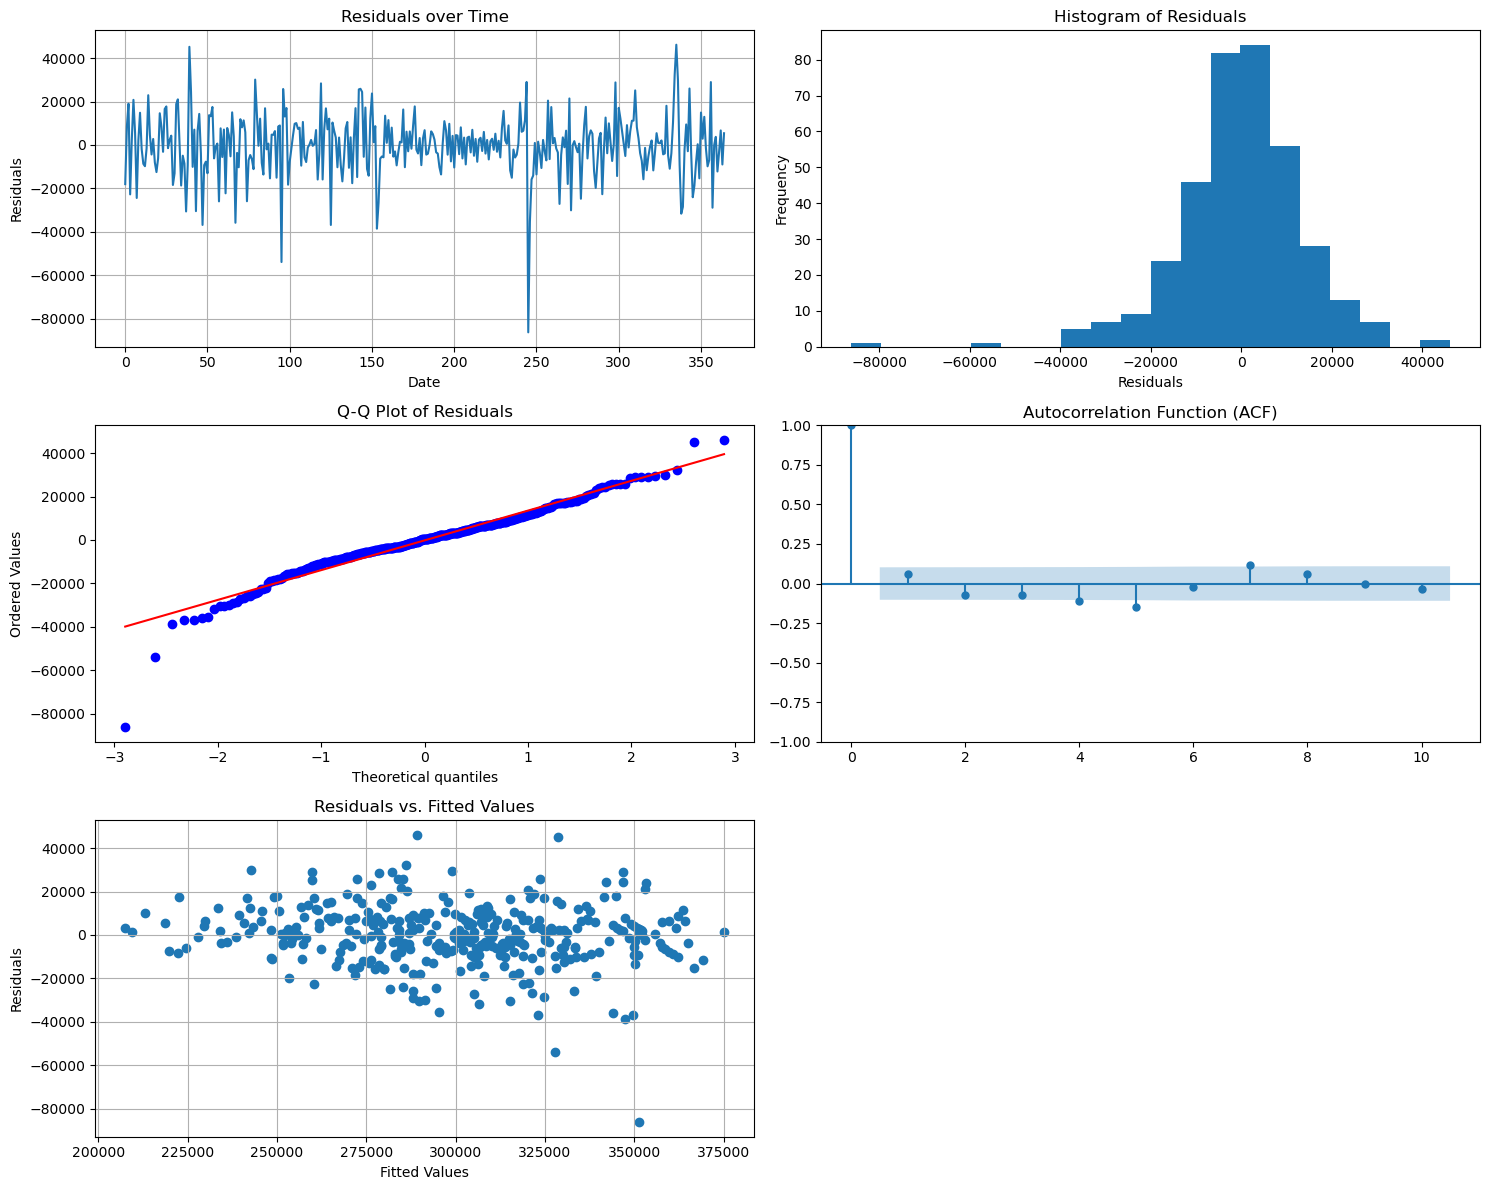

In [104]:
plot_exponential_smoothing_residuals(fit_hw)

In [105]:
# 1. Get Residuals from the Training Data
train_residuals = train_df['Revenue Losses'] - fit_hw.fittedvalues

# 2. Bootstrapping Function
def bootstrap_forecast(train_data, train_residuals, test_len, n_bootstraps=500):
    forecasts = []
    for _ in range(n_bootstraps):
        # 2a. Resample Residuals with Replacement
        resampled_residuals = list(resample(train_residuals, replace=True))

        # 2b. Create "Bootstrapped" Training Data
        bootstrapped_train = train_data + resampled_residuals

        # 2c. Refit the Model on Bootstrapped Data
        boot_model = ExponentialSmoothing(bootstrapped_train,                                 
                                trend="add", 
                                damped_trend=True,
                                seasonal="add", 
                                seasonal_periods=7, 
                                initialization_method="estimated")
        boot_model_fit = boot_model.fit()

        # 2d. Generate Forecasts
        boot_forecast = boot_model_fit.forecast(test_len)
        forecasts.append(boot_forecast)

    return np.array(forecasts)  # Return as a NumPy array for easier manipulation

# 3. Generate Bootstrapped Forecasts
n_bootstraps = 500  # Number of bootstrap iterations (adjust as needed)
boot_forecasts = bootstrap_forecast(train_df['Revenue Losses'], train_residuals, len(test_df), n_bootstraps)

# 4. Calculate Prediction Intervals
alpha = 0.05  # Significance level (for 95% interval)
lower_bounds = np.percentile(boot_forecasts, (alpha / 2) * 100, axis=0)  # Lower percentile
upper_bounds = np.percentile(boot_forecasts, (1 - alpha / 2) * 100, axis=0)  # Upper percentile

c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Us

In [106]:
# Undo box-cox transformation everywhere
test_forecast = inv_boxcox(test_forecast, lam)
lower_bounds = inv_boxcox(lower_bounds, lam)
upper_bounds = inv_boxcox(upper_bounds, lam)
df['Revenue Losses'] = inv_boxcox(df['Revenue Losses'], lam)
train_df_bc = train_df.copy() # save transformed version of train_df
train_df['Revenue Losses'] = inv_boxcox(train_df['Revenue Losses'], lam)
test_df['Revenue Losses'] = inv_boxcox(test_df['Revenue Losses'], lam)

C:\Users\iliu\AppData\Local\Temp\ipykernel_20060\113507523.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



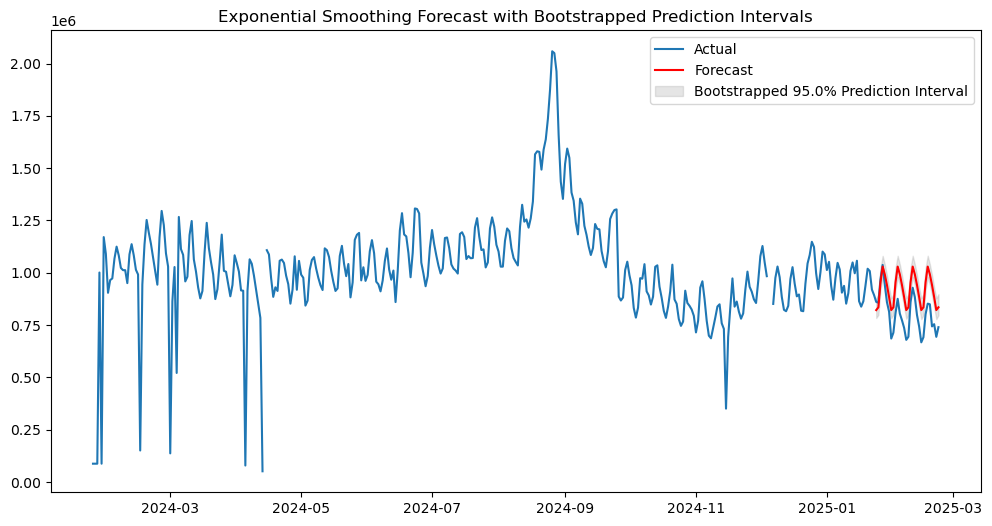

In [107]:
# 5. Plotting
plt.figure(figsize=(12, 6))
plt.plot(orig_df['Date'], orig_df['Revenue Losses'], label='Actual')
plt.plot(test_df['Date'], test_forecast, label='Forecast', color='red')  # Original forecast

plt.fill_between(test_df['Date'], lower_bounds, upper_bounds, color='gray', alpha=0.2, label=f'Bootstrapped {100*(1-alpha)}% Prediction Interval')

plt.title('Exponential Smoothing Forecast with Bootstrapped Prediction Intervals')
plt.legend()
plt.show()

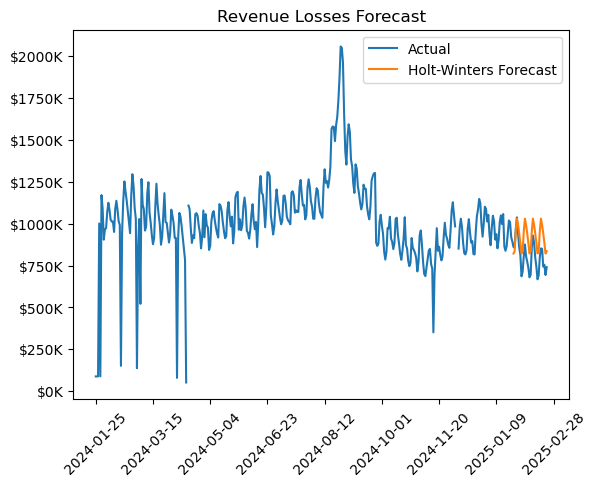

MAE: 118052.83891867557
RMSE: 128132.89163135191


In [108]:
plt.plot(orig_df['Revenue Losses'], label="Actual")
plt.plot(test_forecast, label="Holt-Winters Forecast")
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['Date'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Check MAE, RMSE on test set
mae = mean_absolute_error(test_df['Revenue Losses'], test_forecast)
rmse = root_mean_squared_error(test_df['Revenue Losses'], test_forecast)
print('MAE:', mae)
print('RMSE:', rmse)

c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



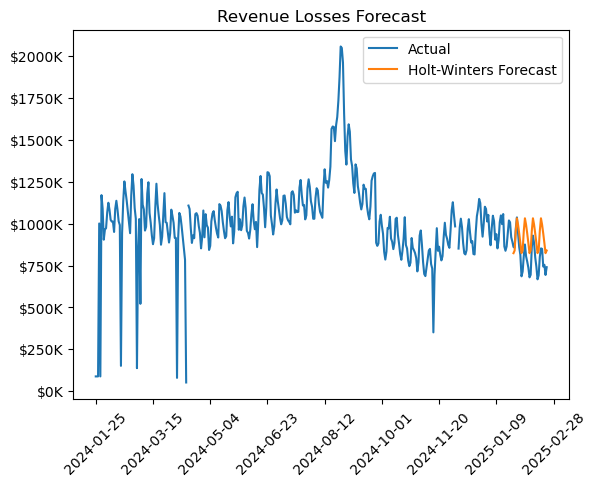

In [109]:
# Automatic
# No box-cox transformation
model_hw = ExponentialSmoothing(train_df['Revenue Losses'], 
                                # trend="add", 
                                # damped_trend=True,
                                seasonal="mul", 
                                seasonal_periods=7, 
                                initialization_method="estimated")
fit_hw = model_hw.fit()
test_forecast = fit_hw.forecast(steps=30)

plt.plot(orig_df['Revenue Losses'], label="Actual")
plt.plot(test_forecast, label="Holt-Winters Forecast")
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['Date'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

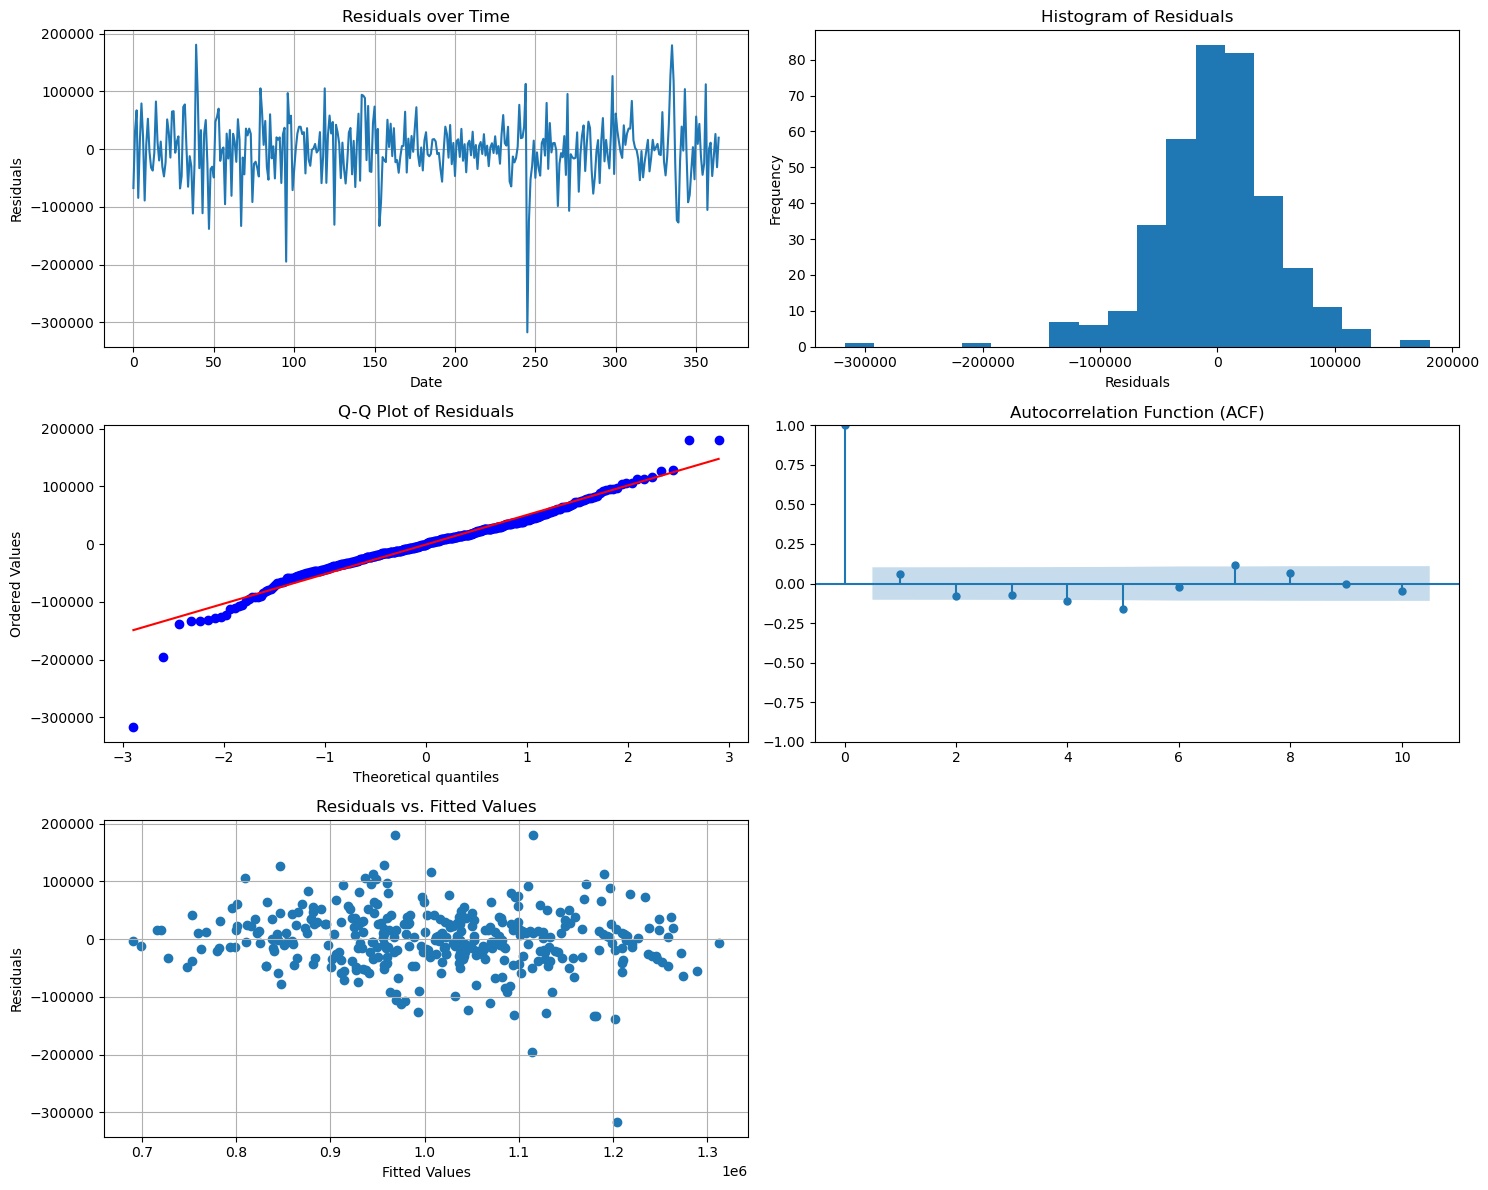

In [110]:
plot_exponential_smoothing_residuals(fit_hw)

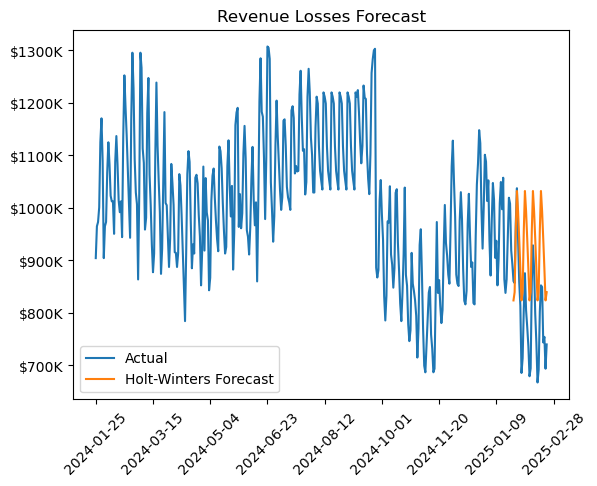

MAE: 119177.06456327214
RMSE: 129609.75094858554


In [111]:
plt.plot(df['Revenue Losses'], label="Actual")
plt.plot(test_forecast, label="Holt-Winters Forecast")
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['Date'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Check MAE, RMSE on test set
mae = mean_absolute_error(test_df['Revenue Losses'], test_forecast)
rmse = root_mean_squared_error(test_df['Revenue Losses'], test_forecast)
print('MAE:', mae)
print('RMSE:', rmse)

Kind of limited in terms of what more can be done here ... more complex forecasting methods may be a better fit for this data (in particular, I think better accounting for cycles or more recent change in trend may be very useful).